# Artificial Neural Network (ANN)

Building an Artificial Neural Network (ANN) on Kepler labelled time series data from [kaggle.com](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data?resource=download), following [exoplanet_ANN.py](https://github.com/nageshsinghc4/Exoplanet-exploration/blob/master/exoplanet_ANN.py) by [nageshsinghc4](https://github.com/nageshsinghc4).

In [1]:
# import necessary packages
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

In [2]:
test_data = pd.read_csv('exoTest.csv').fillna(0)
train_data = pd.read_csv('exoTrain.csv').fillna(0)

In [3]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

In [4]:
#Reduce memory
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
test_data = reduce_memory(test_data)
train_data = reduce_memory(train_data)

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%
Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


Text(0.5, 1.0, 'Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)')

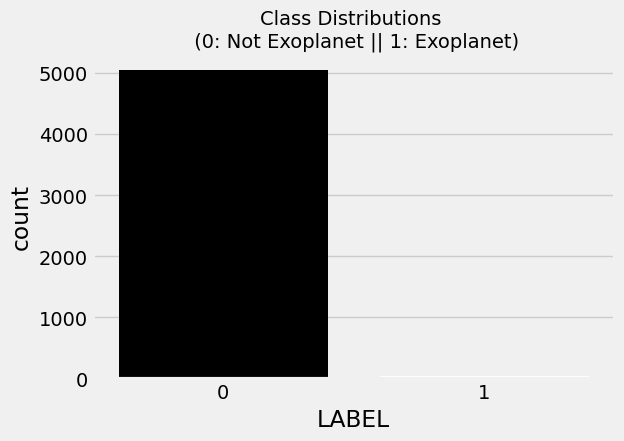

In [6]:
#Visualization:
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)

In [7]:
from pylab import rcParams

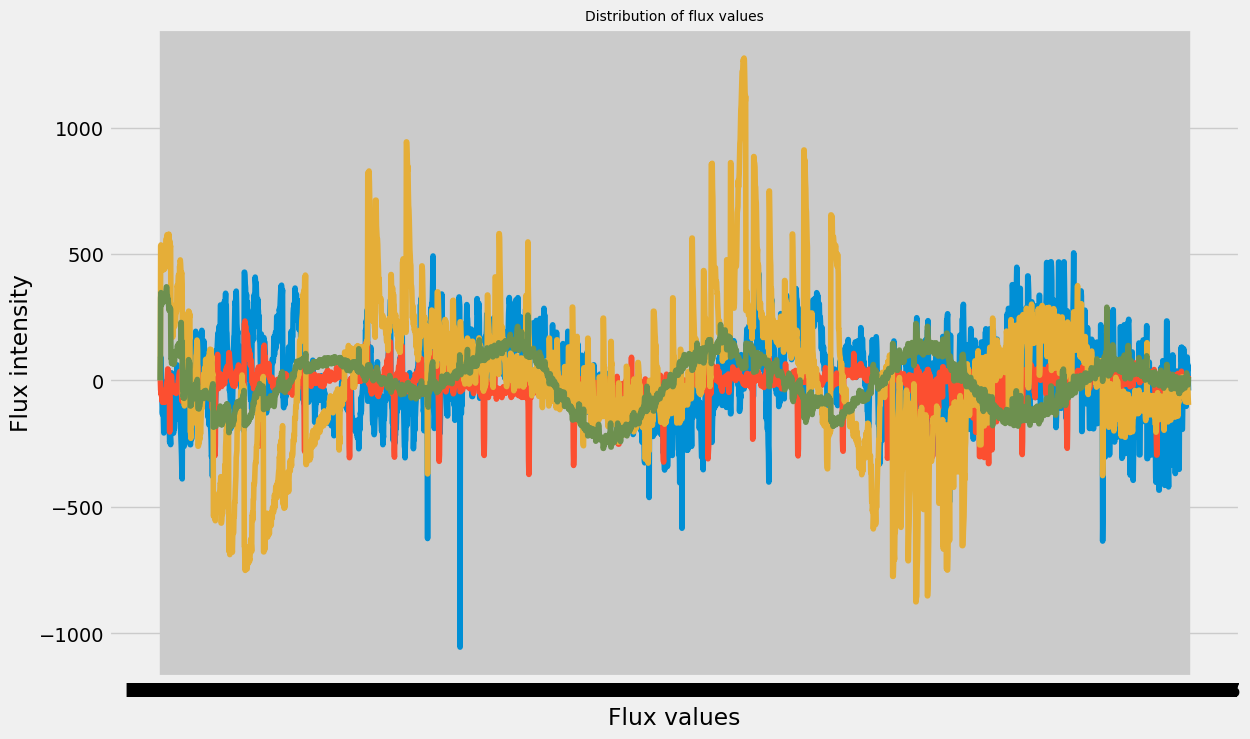

In [8]:
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])
plt.show()

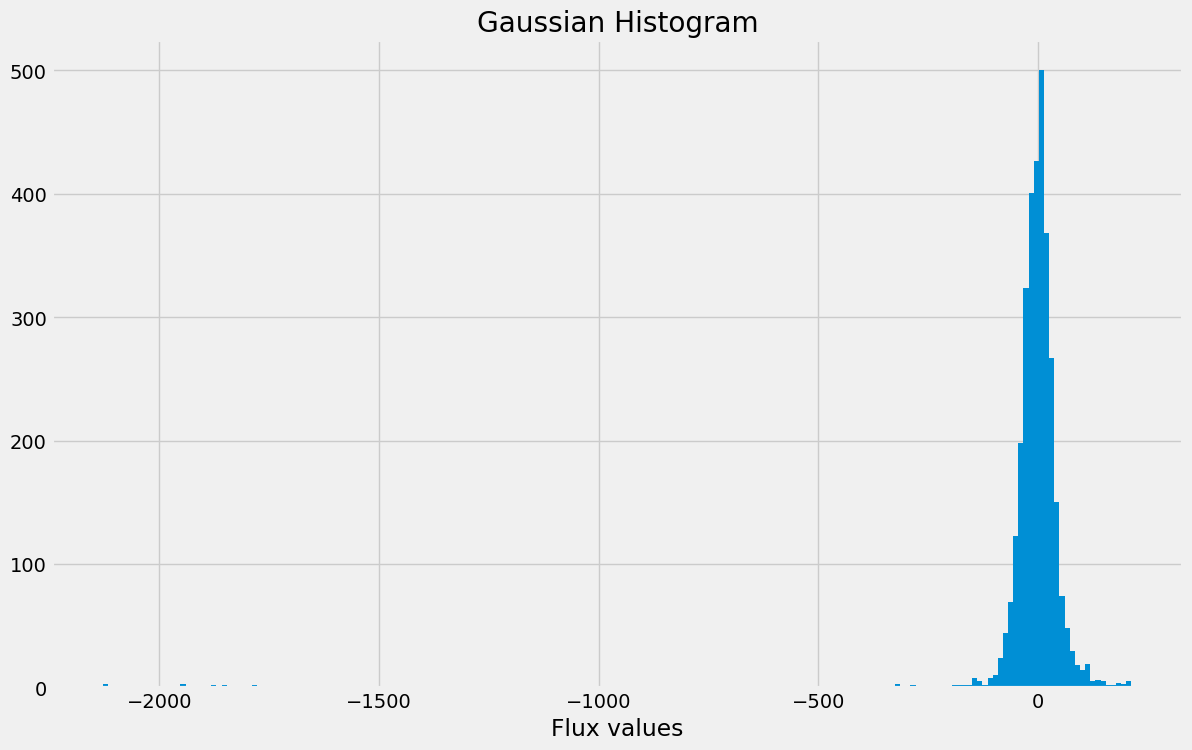

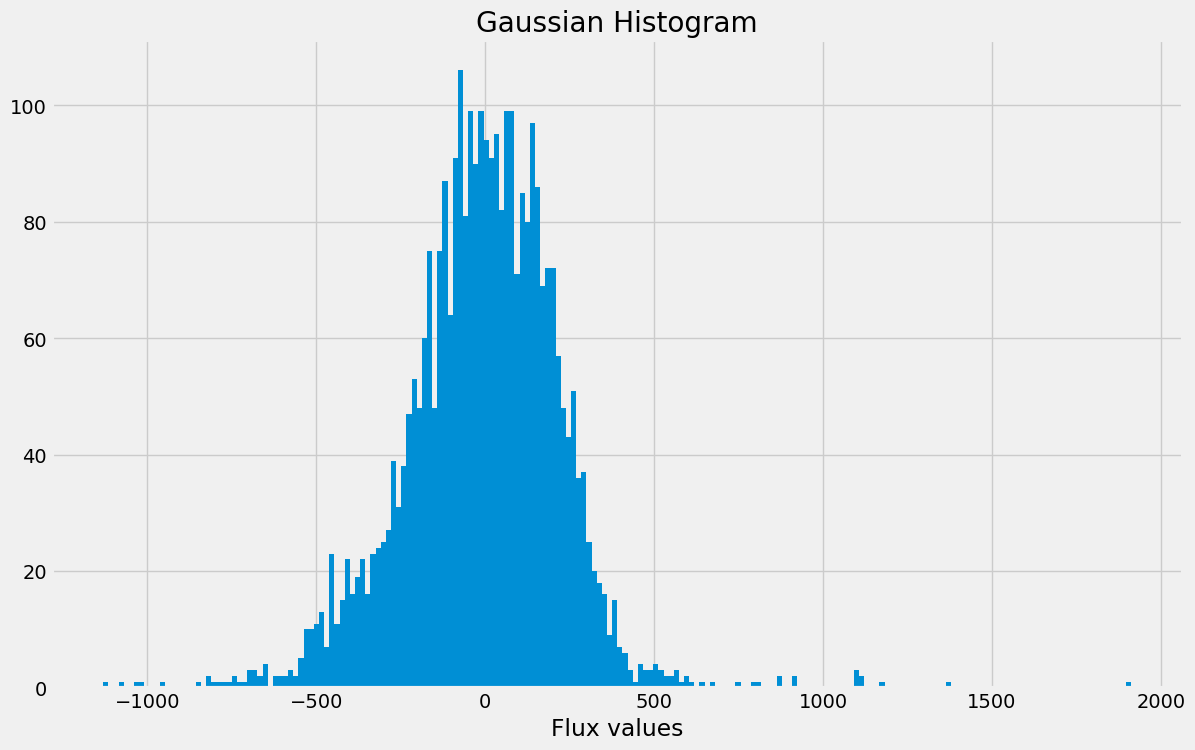

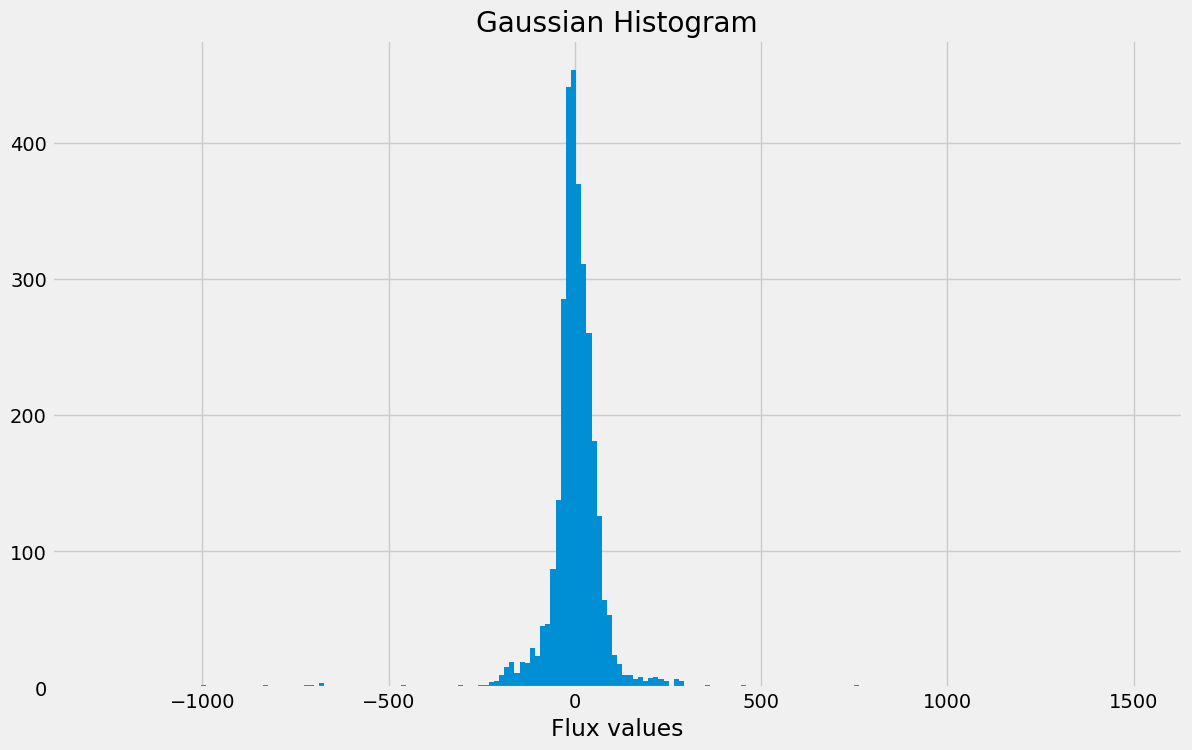

In [9]:
#Gaussian histogram of no exoplanets
labels_1=[100,200,300]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

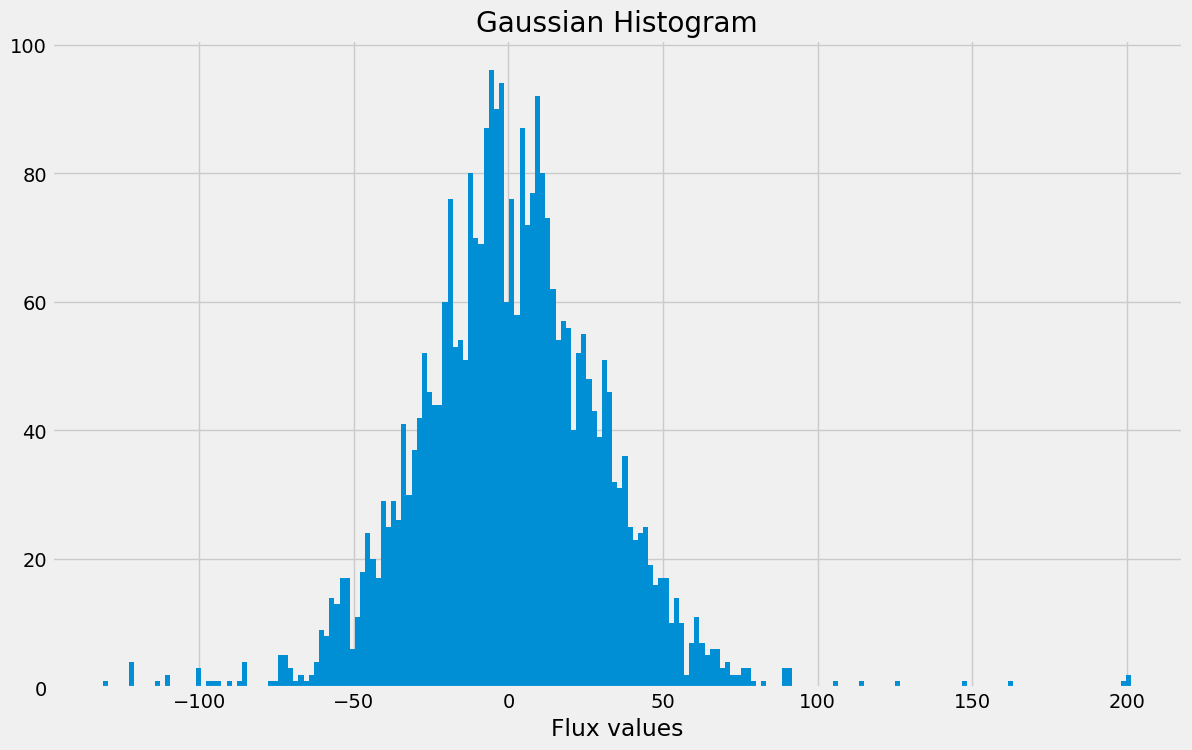

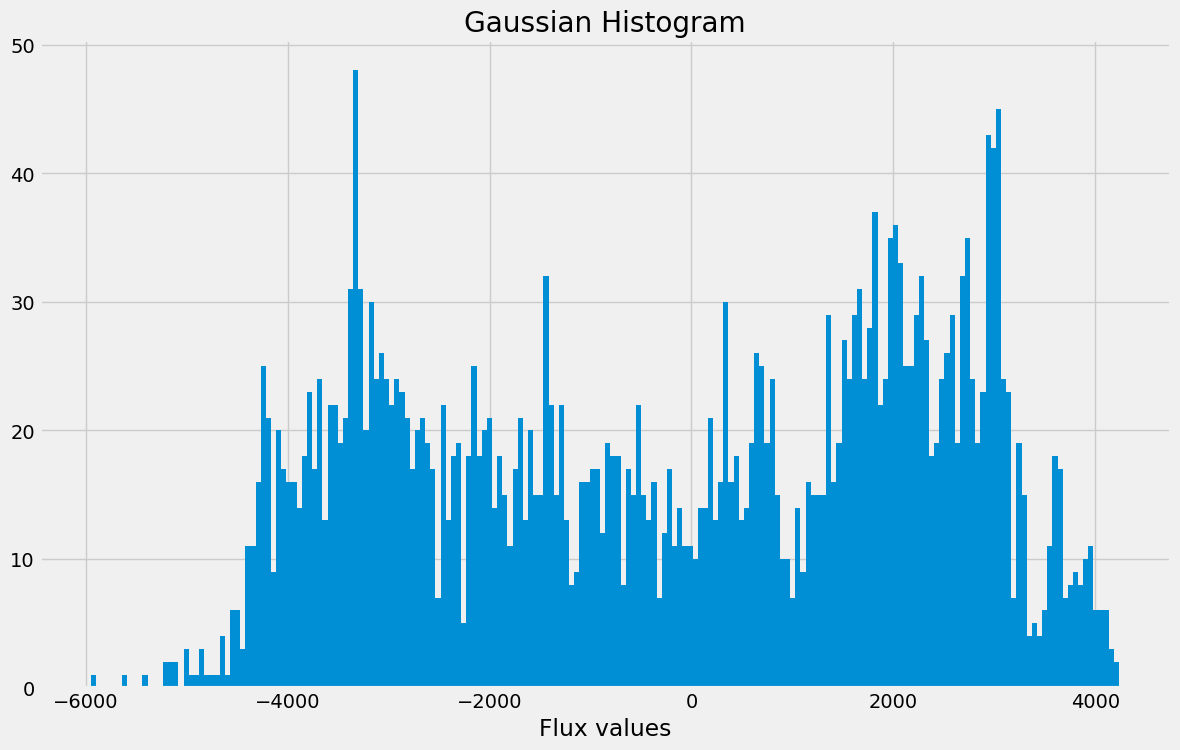

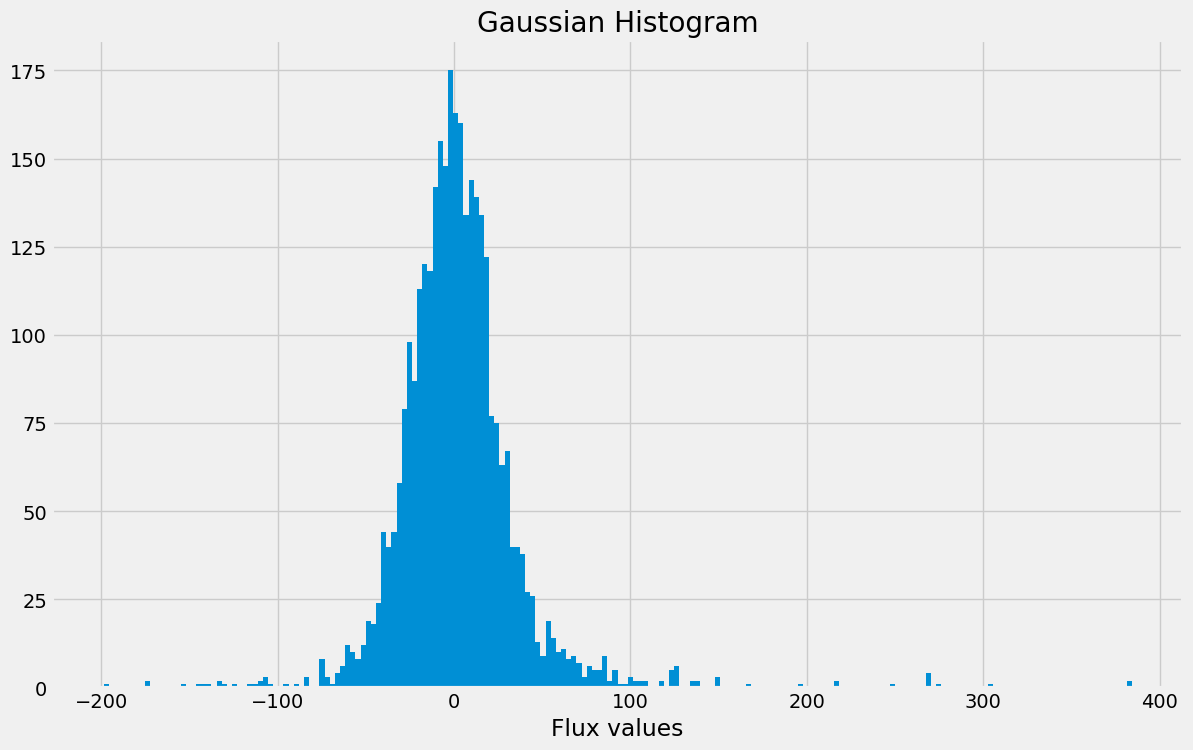

In [10]:
#Gaussian histogram of exoplanets
labels_1=[16,21,25]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

In [11]:
#splitting the data
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

In [12]:
#Normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

In [13]:
#Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

In [14]:
#Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

In [15]:
#Dimentioanlity reduction
from sklearn.decomposition import PCA

In [16]:
pca = PCA() 
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1

This plot tells us that selecting 35 components we can preserve something around 98.8% or 99% 
of the total variance of the data. It makes sense, we’ll not use 100% of our variance,
because it denotes all components, and we want only the principal ones.

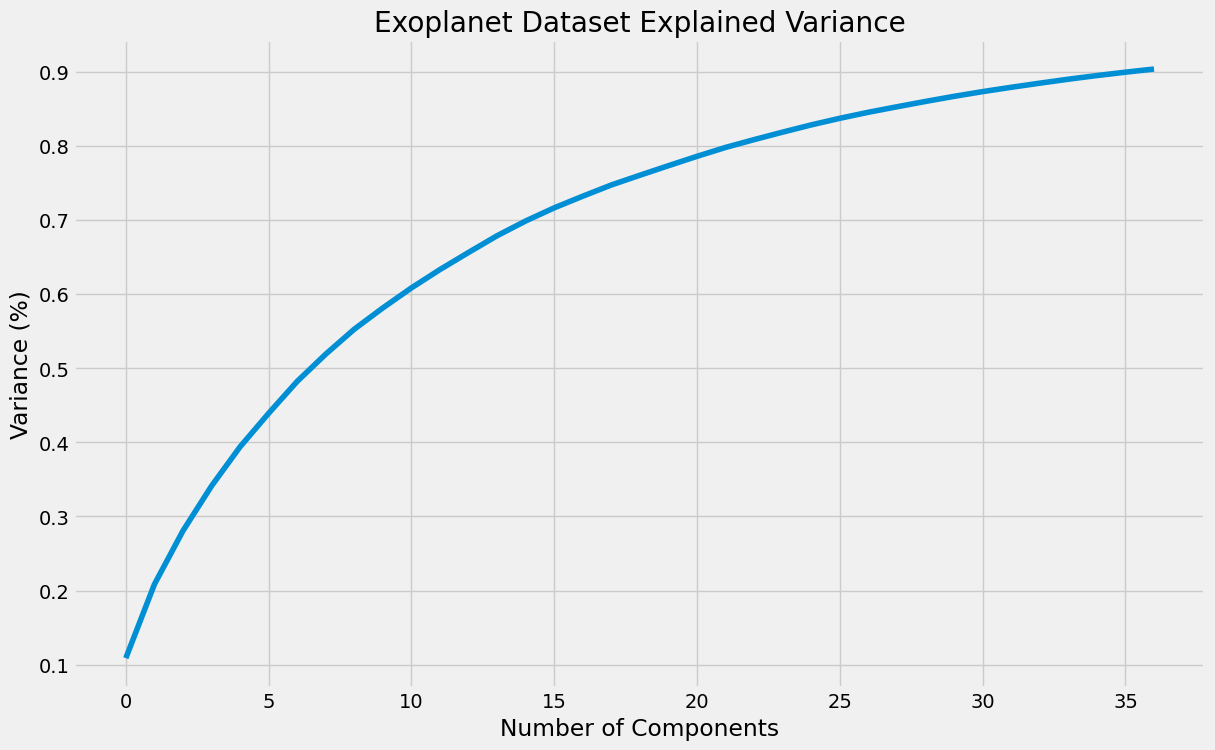

In [17]:
#Apply PCA with n_componenets
pca = PCA(n_components=37)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

RangeIndex(start=0, stop=37, step=1)

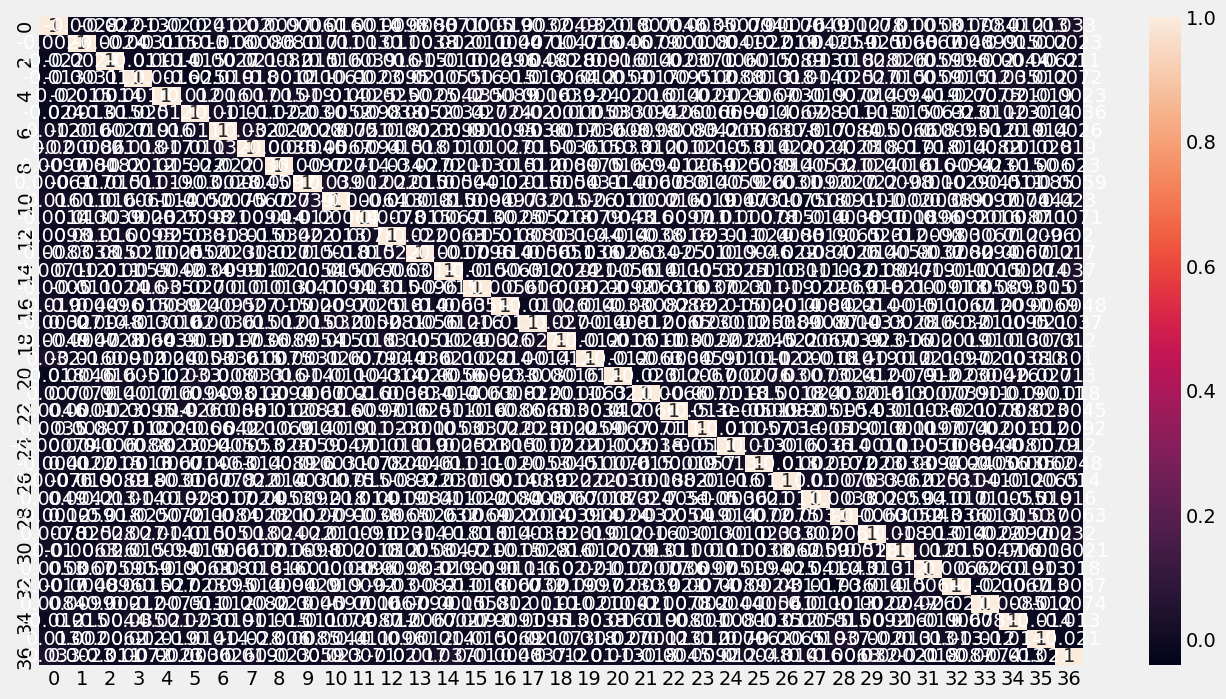

In [18]:
df = pd.DataFrame.from_records(x_train)     
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
df.columns

In [19]:
#Resampling as the data is highly unbalanced.
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 



In [20]:
sm = SMOTE(random_state=27)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel()) 

In [21]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


After oversampling, counts of each label are more balanced.

In [22]:
#Artificial Neural Network
#from tensorflow import set_random_seed
from keras.utils import set_random_seed
set_random_seed(101)

from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library

In [23]:
def build_classifier():
    classifier = Sequential() # initialize neural network
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train_res.shape[1]))
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [24]:
classifier = KerasClassifier(build_fn = build_classifier, epochs = 40)
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

Accuracy mean: 0.9110891089108911
Accuracy variance: 0.05290650364212841


# Alternative algorithms: building ANN from scratch

Investigating further the methodology behind creating Artificial Neural Networks (ANNs) by building one from scratch, with one input layer, one hidden layer and one output layer.

## ANN without any hidden layer

Following [ANN_without_hidden_layer.py](https://github.com/nageshsinghc4/Artificial-Neural-Network-from-scratch-python/blob/master/ANN_without_hidden_layer.py) by [nageshsinghc4](https://github.com/nageshsinghc4).

In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title : Artificial Neural Network with 1 input and 1 output layer from scratch
Created on Wed Oct  9 17:14:14 2019
@author: nageshsinghchauhan
"""

import numpy as np

In [26]:
#create input data
input_set = np.array([[0,1,0],[0,0,1],[1,0,0],[1,1,0],[1,1,1],[0,1,1],[0,1,0]]) #independent variables X
labels = np.array([[1,0,0,1,1,0,1]]) #dependent variable y
labels = labels.reshape(7,1)

In [27]:
#Define Hyperparameters
np.random.seed(42)
weights = np.random.rand(3,1)
bias = np.random.rand(1)
lr = 0.05

In [28]:
#Define Activation Function
def sigmoid(x):
    return 1/(1+np.exp(-x))

#Define derivative of Sigmoid activation function
def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

In [29]:
#Train your model
for epoch in range(25000):
    inputs = input_set
    XW = np.dot(inputs, weights)+ bias
    z = sigmoid(XW)
    error = z - labels
    print(error.sum())
    dcost_dpred = error
    dpred_dz = sigmoid_derivative(z)
    z_del = dcost_dpred * dpred_dz
    inputs = input_set.T
    weights = weights - lr*np.dot(inputs, z_del)
    
    for num in z_del:
        bias -= lr*num

1.8806216715619812
1.8525640899325237
1.8243107340899896
1.7958847686438375
1.7673099081827413
1.7386103353186555
1.70981061515949
1.6809356068569574
1.6520103729182125
1.623060087002853
1.5941099409498616
1.5651850517915373
1.5363103695131097
1.5075105863073248
1.4788100480531448
1.4502326687170073
1.4218018483346397
1.3935403951819836
1.3654704526863837
1.3376134315651074
1.3099899476087358
1.282619765453504
1.2555217486106485
1.2287138159438014
1.202212904708781
1.1760349401952295
1.1501948119375935
1.1247063563951216
1.0995823459377747
1.074834483918001
1.0504734055578753
1.0265086843374711
1.0029488435338814
0.9798013725310017
0.957072747498054
0.9347684560195374
0.9128930252506302
0.8914500531694373
0.8704422425005396
0.8498714368923037
0.829738658942862
0.8100441496859043
0.790787409166752
0.7719672377610798
0.7535817779124228
0.7356285559897645
0.7181045239925073
0.7010061008564724
0.6843292131409233
0.6680693349025218
0.6522215265873573
0.6367804727964091
0.6217405188029252
0.

In [30]:
#Prediction
single_pt = np.array([0,1,0])
result = sigmoid(np.dot(single_pt, weights) + bias)
print(result)

[0.98778682]


In [31]:
# NN with one hidden layer
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

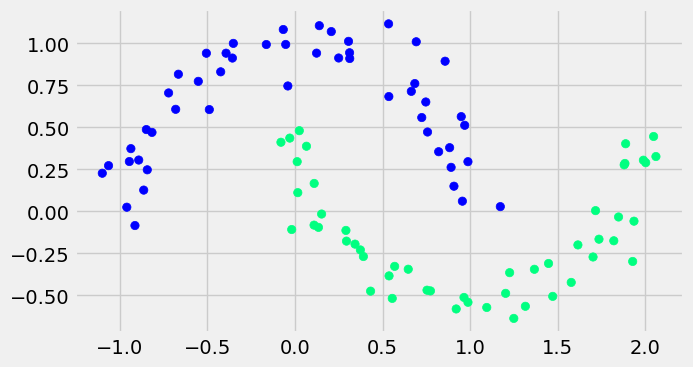

In [32]:
np.random.seed(0)
feature_set, labels = datasets.make_moons(100, noise=0.10)
plt.figure(figsize=(7,4))
plt.scatter(feature_set[:,0], feature_set[:,1], c=labels, cmap=plt.cm.winter)

## ANN with one hidden layer

Following [ANN_with_one_hidden_layer.py](https://github.com/nageshsinghc4/Artificial-Neural-Network-from-scratch-python/blob/master/ANN_with_one_hidden_layer.py) by [nageshsinghc4](https://github.com/nageshsinghc4).

In [33]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

In [34]:
class Config:
    nn_input_dim = 2  # input layer dimensionality
    nn_output_dim = 2  # output layer dimensionality
    # Gradient descent parameters (I picked these by hand)
    epsilon = 0.01  # learning rate for gradient descent
    reg_lambda = 0.01  # regularization strength

In [35]:
#define functions
def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y

def visualize(X, y, model):
    # plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    # plt.show()
    plot_decision_boundary(lambda x:predict(model,x), X, y)
    plt.title("Logistic Regression")

def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    #plt.show()

# Helper function to evaluate the total loss on the dataset
def calculate_loss(model, X, y):
    num_examples = len(X)  # training set size
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += Config.reg_lambda / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1. / num_examples * data_loss

def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [36]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(X, y, nn_hdim, num_passes=20000, print_loss=False):
    # Initialize the parameters to random values. We need to learn these.
    num_examples = len(X)
    np.random.seed(0)
    W1 = np.random.randn(Config.nn_input_dim, nn_hdim) / np.sqrt(Config.nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, Config.nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, Config.nn_output_dim))

    # This is what we return at the end
    model = {}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += Config.reg_lambda * W2
        dW1 += Config.reg_lambda * W1

        # Gradient descent parameter update
        W1 += -Config.epsilon * dW1
        b1 += -Config.epsilon * db1
        W2 += -Config.epsilon * dW2
        b2 += -Config.epsilon * db2

        # Assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" % (i, calculate_loss(model, X, y)))

    return model

In [37]:
def classify(X, y):
    # clf = linear_model.LogisticRegressionCV()
    # clf.fit(X, y)
    # return clf

    pass

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068924
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


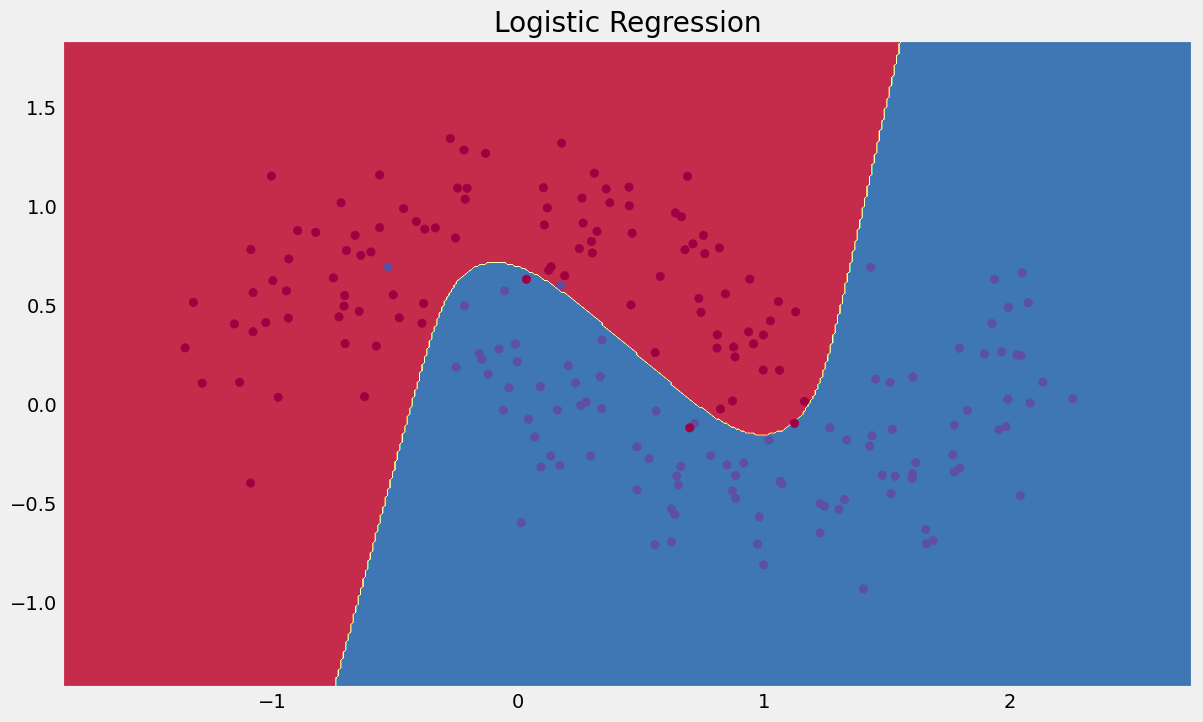

In [38]:
def main():
    X, y = generate_data()
    model = build_model(X, y, 3, print_loss=True)
    visualize(X, y, model)

if __name__ == "__main__":
    main()

# References

- https://www.kdnuggets.com/2020/03/build-artificial-neural-network-scratch-part-2.html
- https://github.com/nageshsinghc4/Artificial-Neural-Network-from-scratch-python/tree/master